In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import glob

datasets = glob.glob('./fashion/*/*.jpg')

import random
random.shuffle(datasets)

print(len(datasets))
datasets[:10]

6612


['./fashion\\modern-street-casual\\style_55dc04751d386.jpg',
 './fashion\\street-sporty-casual\\_FIO0931.jpg',
 './fashion\\avant-garde\\00140fullscreen (5).jpg',
 './fashion\\modern-street-casual\\41942176SS_21_r.jpg',
 './fashion\\modern-chic\\_FIO1287.jpg',
 './fashion\\street-sporty-casual\\_ON_0393.1366x2048.jpg',
 './fashion\\avant-garde\\00260fullscreen (6).jpg',
 './fashion\\modern-street-casual\\00005-Isabel-Marant-Pre-Fall-2020-credit-Bibi-Borthwick.jpg',
 './fashion\\athleisure\\05-Adam-Lippes-Resort-18.jpg',
 './fashion\\modern-chic\\_FIO0536.jpg']

(480, 320, 3)


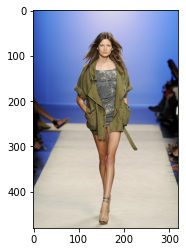

In [3]:
import matplotlib.pyplot as plt

test = plt.imread(datasets[0])
print(test.shape)
plt.imshow(test)

In [97]:
def load(path):
    try: 
        img = tf.keras.preprocessing.image.load_img(path, target_size=(128, 128))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img
    except:
        return None

x_train, y_train = [], []

import tqdm
for i in tqdm.tqdm(range(len(datasets))):
    try:
        x_train.append(load(datasets[i]))
        y_train.append(datasets[i].split('\\')[1])
    except Exception as e:
        print(e)
        pass


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6612/6612 [02:25<00:00, 45.35it/s]


In [98]:
import numpy as np

x_train = np.array(x_train).astype(np.float16)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)


(6612, 128, 128, 3) (6612,)


In [99]:
print(np.unique(y_train, return_counts=True))

labels = {v: i for i, v in enumerate(np.unique(y_train))}
labels
y_train = np.array([labels[v] for v in y_train])
y_train[:10]

(array(['adult-elegance', 'athleisure', 'avant-garde',
       'contemporary-casual', 'modern-chic', 'modern-street-casual',
       'street-sporty-casual'], dtype='<U20'), array([ 511,  273, 1202, 1098, 1256, 1156, 1116], dtype=int64))


array([5, 6, 2, 5, 4, 6, 2, 5, 1, 4])

# VGGNET

In [53]:
def vgg_block(filters, net):
    net = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    return net

tf.keras.backend.clear_session()

X = tf.keras.layers.Input(shape=(128, 128, 3))

net = vgg_block(16, X)
net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(net)

net = vgg_block(16, net)
net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(net)

net = vgg_block(32, net)
net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(net)

net = vgg_block(32, net)
net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(net)

net = vgg_block(64, net)
net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(net)

net = vgg_block(64, net)
net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(net)

net = tf.keras.layers.Flatten()(net)
net = tf.keras.layers.Dense(512)(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation('swish')(net)
net = tf.keras.layers.Dense(512)(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation('swish')(net)

Y = tf.keras.layers.Dense(10, activation="softmax")(net)

model = tf.keras.models.Model(X, Y)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=['accuracy'] 
)

In [54]:
history = model.fit(x_train, y_train, batch_size=128, epochs=1, shuffle=True, validation_split=0.2)

7/7 [==============================] - 2s 344ms/step - loss: 2.2294 - accuracy: 0.2812 - val_loss: 2.2724 - val_accuracy: 0.1450


# RESNET

In [100]:
def residual_block(fin, fout, x):
    if fin != fout:
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Conv2D(fout, kernel_size=1, strides=1, padding="same")(x)
        
    net = tf.keras.layers.BatchNormalization()(x)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(fout // 4, kernel_size=1, strides=1, padding="same")(net)

    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(fout // 4, kernel_size=3, strides=1, padding="same")(net)

    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(fout, kernel_size=1, strides=1, padding="same")(net)

    net = tf.keras.layers.Add()([x, net])
        
    return net

X = tf.keras.layers.Input(shape=(128, 128, 3))

net = tf.keras.layers.Conv2D(8, kernel_size=7, strides=1, padding="same")(X)
net = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(net)

net = residual_block(8, 16, net)
for i in range(2):
    net = residual_block(16, 16, net)
net = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(net)

net = residual_block(16, 32, net)
for i in range(7):
    net = residual_block(32, 32, net)
net = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(net)

net = residual_block(32, 64, net)
for i in range(35):
    net = residual_block(64, 64, net)
net = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(net)

net = residual_block(64, 128, net)
for i in range(2):
    net = residual_block(128, 128, net)
    
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation('swish')(net)
net = tf.keras.layers.GlobalAveragePooling2D()(net)
net = tf.keras.layers.Dropout(0.5)(net)

net = tf.keras.layers.Dense(1000)(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation('swish')(net)

net = tf.keras.layers.Dense(512)(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation('swish')(net)

Y = tf.keras.layers.Dense(10, activation='softmax')(net)

model = tf.keras.models.Model(X, Y)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

hist = {
    'loss': [], 'val_loss': [],
    'accuracy': [], 'val_accuracy': []
}

In [102]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_split=0.2)

hist['loss'] += history.history['loss']
hist['val_loss'] += history.history['val_loss']
hist['accuracy'] += history.history['accuracy']
hist['val_accuracy'] += history.history['val_accuracy']

Epoch 1/10
83/83 [==============================] - 30s 365ms/step - loss: 0.4972 - accuracy: 0.8342 - val_loss: 0.7085 - val_accuracy: 0.7785
Epoch 2/10
83/83 [==============================] - 53s 639ms/step - loss: 0.4174 - accuracy: 0.8614 - val_loss: 1.3775 - val_accuracy: 0.5911
Epoch 3/10
83/83 [==============================] - 65s 785ms/step - loss: 0.4157 - accuracy: 0.8612 - val_loss: 1.1351 - val_accuracy: 0.6765
Epoch 4/10
83/83 [==============================] - 67s 806ms/step - loss: 0.3740 - accuracy: 0.8752 - val_loss: 1.7101 - val_accuracy: 0.6092
Epoch 5/10
83/83 [==============================] - 67s 813ms/step - loss: 0.3297 - accuracy: 0.8913 - val_loss: 1.0510 - val_accuracy: 0.7143
Epoch 6/10
83/83 [==============================] - 67s 806ms/step - loss: 0.3160 - accuracy: 0.8924 - val_loss: 1.1796 - val_accuracy: 0.6561
Epoch 7/10
83/83 [==============================] - 73s 876ms/step - loss: 0.2743 - accuracy: 0.9058 - val_loss: 0.8430 - val_accuracy: 0.7687

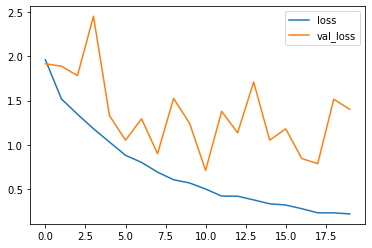

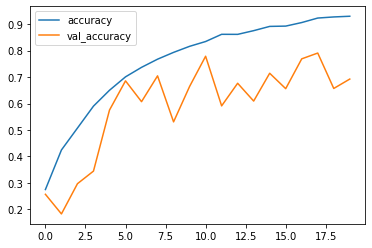

In [103]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
model.summary()

## densnet

In [42]:
def dense_block(growth, x):
    h = tf.keras.layers.BatchNormalization()(x)
    h = tf.keras.layers.Activation("swish")(h)
    h = tf.keras.layers.Conv2D(growth, (1, 1), padding="same")(h)

    h = tf.keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.Activation("swish")(h)
    h = tf.keras.layers.Conv2D(growth, (3, 3), padding="same")(h)

    return tf.keras.layers.Concatenate()([x, h])

def transition(fnum, x):
    h = tf.keras.layers.BatchNormalization()(x)
    h = tf.keras.layers.Activation("swish")(h)
    h = tf.keras.layers.Conv2D(fnum // 2, (1, 1), padding="same")(h)
    h = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=2, padding="same")(h)
    return h


In [43]:
tf.keras.backend.clear_session()

X = tf.keras.layers.Input(shape=(128, 128, 3))

net = tf.keras.layers.Conv2D(64, (7, 7), padding="same")(X)
net = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)(net)

for i in range(6):
    net = dense_block(32, net)
net = transition(256, net)

for i in range(12):
    net = dense_block(32, net)
net = transition(512, net)

for i in range(24):
    net = dense_block(32, net)
net = transition(1024, net)

for i in range(16):
    net = dense_block(32, net)
net = transition(1024, net)

net = tf.keras.layers.Flatten()(net)
net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(256)(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation("swish")(net)
net = tf.keras.layers.Dense(256)(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation("swish")(net)
Y = tf.keras.layers.Dense(10, activation='softmax')(net)

model = tf.keras.models.Model(X, Y)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [46]:
history = model.fit(x_train[:1000], y_train[:1000], batch_size=32, epochs=1, shuffle=True, validation_split=0.2)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,288,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_24/Conv2D (defined at <ipython-input-46-de6e91b9dfbb>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_111336]

Function call stack:
train_function
